# Pricing simulations around product classes

For more information on the classification algorithm and a high-level overview of this notebook, [check out our article on atoti.io](https://www.atoti.io/data-dive-how-to-improve-pricing-strategies-with-a-set-of-checkout-receipts/).

## Introduction

In this notebook, we will showcase a simplified example of how a retailer can achieve a better price perception from its customers, while keeping or even slightly increasing its margins.

## Classification algorithm

A classification algorithm has already been run on three months of receipts to classify the products into three categories:
- Driver products: Those are products that make people come to the store, their price is often compared to the competition. A typical example would be a drill. 
- Complementary products: Those are products that people do not intend to buy before coming to the store, they generate so called "opportunity" sales. Their price is most of the time not known. Examples are drill batteries or chewing gums near the checkout area.
- Independent products: This third group of products contains products that are often sold alone. They tend to be large and more expensive and thus also have a tendency to be compared.

## Importing Atoti, having a first look at the data

First we will start Atoti, load the products referential and have a look at the classification algorithm result on our dataset.

In [1]:
import atoti
from atoti.config import create_config

# Tell atoti to load the database containing the UI dashboards
config = create_config(metadata_db="./metadata.db")

session = atoti.create_session(config=config)

Welcome to atoti 0.4.0.20200519221045!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


Loading the products referential with all the products information

In [2]:
products_store = session.read_csv(
    "s3://data.atoti.io/notebooks/products-classification/products_referential.csv",
    store_name="Products_store",
    sep=";",
)
products_store.head()

The store has been sampled because the sampling mode policy has breached.Call Session.load_all_data()  to trigger the full load of the data.


,ProductId,Product Name,Brand
0,1,Product 1,None
1,2,Product 2,None
2,3,Product 3,Brand 1
3,4,Product 4,Brand 1
4,5,Product 5,Brand 1


Then loading the result of the classification algorithm

In [3]:
classified_products_store = session.read_csv(
    "s3://data.atoti.io/notebooks/products-classification/classified_products.csv",
    keys=["ProductId"],
    store_name="classified_products",
)
classified_products_store.head()

,Class,edge_purchases,n_purchases,solo_purchases
ProductId,,,,
69253,Complementary,2052,2628,576
23395,Complementary,728,959,231
53048,Driver,447,724,277
94770,Complementary,4479,5464,985
105666,Driver,1238,1764,526


And join them together

In [4]:
classified_products_store.join(products_store, mapping={"ProductId": "ProductId"})

We can then create a cube

In [5]:
cube = session.create_cube(classified_products_store, "products_cube")

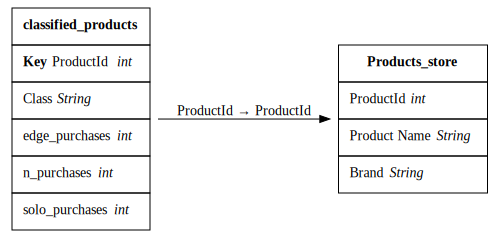

In [6]:
cube.schema

In [7]:
# We can now load all the data so that visualizations operate on the entire dataset.
# NB: as a best practice, to optimize speed while exploring your data, we recommend keeping the default sampling mode enabled.
#     Once the model is ready, as it is the case in this notebook, you may call session.load_all_data() after creating the cube.
session.load_all_data()

And have a first look at the data

In [9]:
cube.visualize("Percentage of products per class pie chart")

Install and enable the atoti JupyterLab extension to see this widget.

## Computing the margin
The margin formula for a particular product is: $(Selling Price - Purchase Price) \times Quantity Sold$

To perform that calculation we will load the purchase and selling prices tables and join them to the current data structure.

In [10]:
purchase_prices_store = session.read_csv(
    "s3://data.atoti.io/notebooks/products-classification/purchase_prices.csv",
    keys=["ProductId"],
    store_name="purchase_prices",
)
purchase_prices_store.head()

,PurchasePrice
ProductId,
76939.0,9.91
82520.0,1.80
82521.0,1.80
82522.0,1.80
82523.0,1.80


In [11]:
selling_prices_store = session.read_csv(
    "s3://data.atoti.io/notebooks/products-classification/selling_prices.csv",
    keys=["ProductId"],
    store_name="selling_prices",
)
selling_prices_store.head()

,SellingPrice
ProductId,
6707.0,4.20
26332.0,26.35
27200.0,7.65
27480.0,178.20
46379.0,260.15


In [12]:
classified_products_store.join(
    purchase_prices_store, mapping={"ProductId": "ProductId"}
)
classified_products_store.join(selling_prices_store, mapping={"ProductId": "ProductId"})

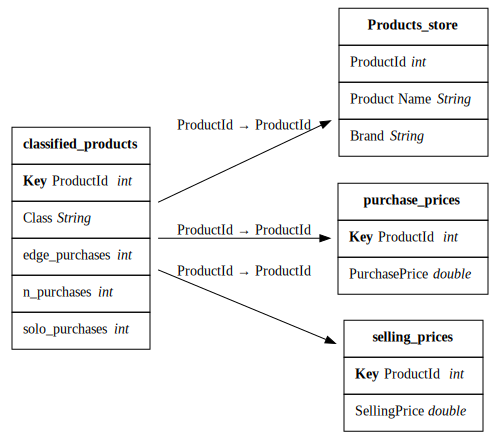

In [13]:
cube.schema

Let's now add the margin measure

In [14]:
m = cube.measures
h = cube.hierarchies
lvl = cube.levels

Because selling and purchase prices are different per products, we have to compute the margin at ProductId level using parameter "scope", and then aggregate it as a sum above this level.

In [15]:
m["Margin.SUM"] = atoti.agg.sum(
    (m["SellingPrice.VALUE"] - m["PurchasePrice.VALUE"])
    * classified_products_store["n_purchases"],
    scope=atoti.scope.origin(lvl["ProductId"]),
)

In [17]:
cube.visualize("Margin per product class")

Install and enable the atoti JupyterLab extension to see this widget.

Atoti visualizations are available both in the notebook, but also from the dedicated application.  
Run the two cells below to get a link to a summary dashboard of all what was done so far.

In [17]:
m["SellingPrice.MEAN"] = atoti.agg.mean(selling_prices_store["SellingPrice"])

In [18]:
session.url + "/#/dashboard/326"

'http://localhost:38781/#/dashboard/326'

If you wish to play with the UI and explore the data by yourself, [you can have a look at our UI documentation here](https://www.activeviam.com/activeui/documentation/index.html).

## Custom hierarchy

In [19]:
h["Products"] = {
    "Product Brand": lvl["Brand"],
    "Product Label": lvl["Product Name"],
}

In [23]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

## Computing the price index

There are different existing formulas for the price index but the idea behind is always the same: the price index is a measurement of where a retailer is positioned compared to one or multiple of its competitors.

The formula we will use in this example compares a product price to the average price found among the competitors, measuring at which percentage of this average competitors price the product is.  

We will weight the price index indicator by the margin when aggregating above product level so that we later optimize the price index for products that contribute the most to our margin.  
Other commonly used formulas weight by sales quantity or revenue.

### Price Index Formula

# $100 \times \frac{\sum_{p \in Products}\frac{Selling Price(p)}{Average Competitor Price(p)} \times Margin(p)}{\sum_{p \in Products}Margin(p)}$

### Loading Competitor prices data

In [24]:
competitor_prices_store = session.read_csv(
    "s3://data.atoti.io/notebooks/products-classification/competitor_prices.csv",
    keys=["ProductId", "CompetitorName"],
    store_name="Competitor_prices_store",
)

In [25]:
classified_products_store.join(
    competitor_prices_store, mapping={"ProductId": "ProductId"}
)

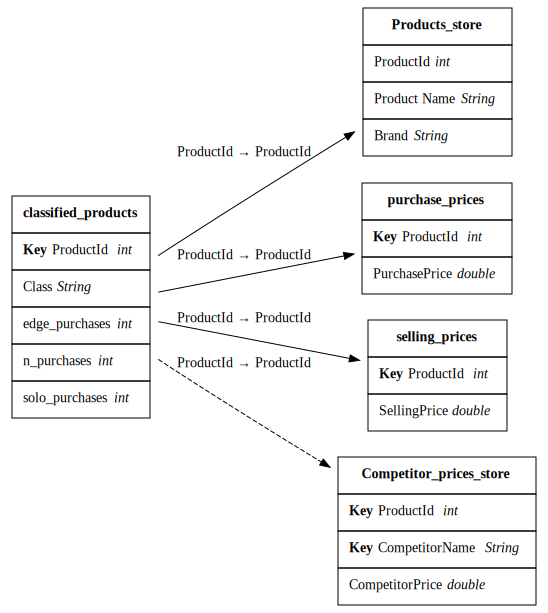

In [26]:
cube.schema

### Creating the price index measure

The "scope" parameters enables you to have a different aggregation strategy below the "on" level.  
In the following cell, everything above Product (ProductId) level is aggregated as a sum, while below the product level we find the previous formula, that does an average on the competitor prices just for one particular product.

In [27]:
m["CompetitorPrice.MEAN"] = atoti.agg.mean(m["CompetitorPrice.VALUE"])

In [29]:
price_index_numerator = atoti.agg.sum(
    (m["SellingPrice.MEAN"] * m["Margin.SUM"]) / m["CompetitorPrice.MEAN"],
    scope=atoti.scope.origin(lvl["ProductId"]),
)

# Some products have no competitor price or selling price.
# We exclude them from the denominator for consistency with the numerator
price_index_denominator = atoti.agg.sum(
    atoti.where(
        (m["CompetitorPrice.MEAN"] != None) & (m["SellingPrice.MEAN"] != None),
        m["Margin.SUM"],
    ),
    scope=atoti.scope.origin(lvl["ProductId"]),
)

In [30]:
m["Price Index"] = 100 * price_index_numerator / price_index_denominator

The price index measure is now created accordingly to the formula.

We can see below that our driver products are in fact a bit more expensive than the average market price while we are quite competitive on the complementary products, which is the opposite of our goal.

In [29]:
cube.visualize("Price index per competitor")

Install and enable the Atoti JupyterLab extension to see this widget.

## Simulate Price Strategies

Complementary products are usually less expensive than those of the other two categories and people tend to ignore their price. This means that an increase in price does not necessarily mean a drop in sales.  
In a first simulation we will try to assess how much margin we can make if we increase their price by 10%.

We will first import our pricing methods: in this example a very simple pricing functions from our `pricer.py` file.

In [16]:
from price_engine import pricer

Then we simply generate a new price list where the prices of all complementary products has been increased by 10%.  
For that matter we need to pass as argument the initial list of prices, and information about the classification.

In [17]:
import pandas as pd

selling_prices = pd.read_csv(
    "http://data.atoti.io/notebooks/products-classification/selling_prices.csv", sep=";"
)
classified_products = pd.read_csv(
    "http://data.atoti.io/notebooks/products-classification/classified_products.csv",
    sep=";",
)
initial_price_list_with_classes = selling_prices.merge(classified_products)

In [32]:
# selling_prices_with_costly_complementary_products = pricer.increase_price_by_percentage_on_class(
#     initial_price_list_with_classes, 10, "Complementary"
# )

Once this is done, what we will do is re-load the price list, but instead of replacing the previous one, we will load it into a new scenario called "Increased price on complementary products". All KPIs defined previously such as the price index will be re-computed on the fly which will enable us to compare scenarios and their benefits.

In [31]:
# selling_prices_store.scenarios["Increased price on complementary products"].load_pandas(
#     selling_prices_with_costly_complementary_products
# )

price_strategies = cube.setup_simulation(
    "Price Strategies",
    levels=[lvl["Class"], lvl["ProductId"]],
    multiply=[m["SellingPrice.VALUE"]],
)

complementary_increase = price_strategies.scenarios["10% complementary increase"]

In [32]:
complementary_increase += ("Complementary", "*", 1.1)

Traceback (most recent call last):
  File "/home/jbe/.conda/envs/atoti-latest/lib/python3.8/site-packages/atoti/exceptions.py", line 215, in catch_py4j_exceptions
    return method(*args, **kwargs)
  File "/home/jbe/.conda/envs/atoti-latest/lib/python3.8/site-packages/atoti/_java_api.py", line 778, in insert_multiple_on_store_scenario
    self.java_api.insertMultipleOnStoreBranch(
  File "/home/jbe/.conda/envs/atoti-latest/lib/python3.8/site-packages/atoti/vendor/atotipy4j/java_gateway.py", line 1313, in __call__
    return_value = get_return_value(
  File "/home/jbe/.conda/envs/atoti-latest/lib/python3.8/site-packages/atoti/vendor/atotipy4j/protocol.py", line 322, in get_return_value
    raise Py4JJavaError(
Py4JJavaError: An error occurred while calling o2.insertMultipleOnStoreBranch.
: com.qfs.fwk.services.BadArgumentException: [400] Invalid records to add
	at com.qfs.store.service.impl.DatastoreService.parseRows(DatastoreService.java:1112)
	at com.qfs.store.service.impl.DatastoreSe

We can see below that this represents a gain of 12 million per year, while increasing the index dramatically from 98.52 to 108.37

In [ ]:
cube.visualize("Comparison of the two scenarios per class")

Install and enable the Atoti JupyterLab extension to see this widget.

As seen before a better strategy is to improve the price image by being more competitive on the driver and independent products, hence lowering the prices of those products, while compensating the losses in margin by increasing the prices of the complementary products.  

We will give our initial price list to a prices optimizer that will do just that, and then load the resulting price list into a third scenario named "Optimized price index" that we will be able to compared to the two previous.

In [ ]:
selling_prices_for_optimized_price_index = pricer.optimize_price_index(
    initial_price_list_with_classes
)

In [ ]:
selling_prices_store.scenarios["Optimized price index"].load_pandas(
    selling_prices_for_optimized_price_index
)

The result as we can see below is much better since we have been able to very slightly increase our global margin, while being much more competitive on the Driver products

In [ ]:
cube.visualize("Results summary")

In [ ]:
cube.visualize("Price index comparison across scenarios (per class)")

You can also have a look at our second summary dashboard of the simulation part (run the next cell to get the link)

In [ ]:
session.url + "/#/dashboard/a17"